In [1]:
import keras

from scipy.ndimage.filters import gaussian_filter
from scipy import misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class CombineGradients(Layer):

    def call(self, inputs, **kwargs):
        Gx = inputs[0]
        Gy = inputs[1]
        grad = K.sqrt( Gx**2 + Gy**2 )
        return grad

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [3]:
class Normalize(Layer):
    
    def call(self, inputs, **kwargs):
        res = K.identity(inputs[:, :, :, 0])
        
        minimum = K.min(res, axis=1)
        minimum = K.min(minimum, axis=1)
        minimum = K.repeat_elements(minimum, 256, axis=0)
        minimum = K.reshape(minimum, shape=(K.shape(res)[0], 256))
        minimum = K.repeat(minimum, 256)
        res -= minimum

        maximum = K.max(res, axis=1)
        maximum = K.max(maximum, axis=1)
        maximum = K.repeat_elements(maximum, 256, axis=0)
        maximum = K.reshape(maximum, shape=(K.shape(res)[0], 256))
        maximum = K.repeat(maximum, 256)
        res *= K.constant(1.) / maximum
        return res
    
    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [4]:
from keras.layers import Input
from keras.layers import Conv2D
from keras.models import Model

input_layer = Input(shape=(None, None, 1), name='input')
Gx = Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='tanh', name='Gx')(input_layer)
Gy = Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='tanh', name='Gy')(input_layer)
grad = CombineGradients(name='G')([Gx, Gy])
out = Normalize(name='output')(grad)

model = Model(inputs=input_layer, outputs=out)
model.compile(optimizer='adam', loss='mse')

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input (InputLayer)               (None, None, None, 1) 0                                            
____________________________________________________________________________________________________
Gx (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
Gy (Conv2D)                      (None, None, None, 1) 10          input[0][0]                      
____________________________________________________________________________________________________
G (CombineGradients)             (None, None, None, 1) 0           Gx[0][0]                         
                                                                   Gy[0][0]                

In [5]:
from skimage.filters import threshold_otsu, threshold_local

def apply_threshold(input_image, threshold, high_value, low_value):
    assert input_image.shape == threshold.shape
    diff = input_image - threshold
    
    result = np.ones(shape=input_image.shape) * high_value
    low_indices = diff[:,:] < 0
    result[low_indices] = low_value
    return result

def global_otsu_thresholding(input_image, high_value=1, low_value=0):
    global_thresh = threshold_otsu(input_image)
    return apply_threshold(input_image, 
                           np.ones(shape=input_image.shape) * global_thresh, 
                           high_value, 
                           low_value)

In [6]:
def get_smple(path, scale, reshape):
    img = misc.imread(path, mode='L')
    img = misc.imresize(img, size=(256, 256))
    img = np.array(img, dtype=np.float32)
    if reshape:
        img = np.reshape(img, newshape=img.shape+(1,))
    if scale:
        img /= 255.
    return img

def get_data(paths, scale=False, reshape=True):
    res = []
    for path in paths:
        res.append(get_smple(path, scale, reshape))
    return np.array(res, dtype=np.float32)

In [7]:
import os
train_input_paths = ['./BSDS500/images/train/'+path for path in os.listdir('./BSDS500/images/train/') if path.endswith('.jpg')]
test_input_paths = ['./BSDS500/images/test/'+path for path in os.listdir('./BSDS500/images/test/') if path.endswith('.jpg')]
valid_input_paths = ['./BSDS500/images/val/'+path for path in os.listdir('./BSDS500/images/val/') if path.endswith('.jpg')]
train_input = get_data(train_input_paths, True)
test_input = get_data(test_input_paths, True)
valid_input = get_data(valid_input_paths, True)

train_label_paths = ['./BSDS500/labels/train/'+path for path in os.listdir('./BSDS500/labels/train/') if path.endswith('-1.jpg')]
test_label_paths = ['./BSDS500/labels/test/'+path for path in os.listdir('./BSDS500/labels/test/') if path.endswith('-1.jpg')]
valid_label_paths = ['./BSDS500/labels/valid/'+path for path in os.listdir('./BSDS500/labels/valid/') if path.endswith('-1.jpg')]
train_label = get_data(train_label_paths, True, False)
test_label = get_data(test_label_paths, True, False)
valid_label = get_data(valid_label_paths, True, False)

print(len(train_input_paths), len(test_input_paths), len(valid_input_paths))
print(len(train_label_paths), len(test_label_paths), len(valid_label_paths))

200 200 100
200 200 100


## Train the model

In [11]:
model.fit(train_input, train_label, batch_size=33, epochs=77, validation_data=(valid_input, valid_label))

Train on 200 samples, validate on 100 samples
Epoch 1/77
200/200 [==============================] - 5s - loss: 0.0396 - val_loss: 0.0293
Epoch 2/77
200/200 [==============================] - 6s - loss: 0.0269 - val_loss: 0.0237
Epoch 3/77
200/200 [==============================] - 6s - loss: 0.0239 - val_loss: 0.0234
Epoch 4/77
200/200 [==============================] - 5s - loss: 0.0242 - val_loss: 0.0238
Epoch 5/77
200/200 [==============================] - 5s - loss: 0.0242 - val_loss: 0.0234
Epoch 6/77
200/200 [==============================] - 5s - loss: 0.0237 - val_loss: 0.0232
Epoch 7/77
200/200 [==============================] - 5s - loss: 0.0236 - val_loss: 0.0232
Epoch 8/77
200/200 [==============================] - 5s - loss: 0.0236 - val_loss: 0.0231
Epoch 9/77
200/200 [==============================] - 5s - loss: 0.0235 - val_loss: 0.0230
Epoch 10/77
200/200 [==============================] - 6s - loss: 0.0235 - val_loss: 0.0230
Epoch 11/77
200/200 [======================

In [12]:
# Save the trained model
model.save('edge_detector.model')

## Understanding what's goind on...

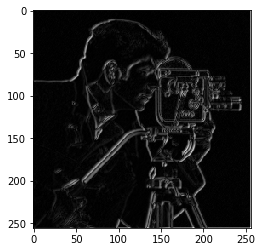

In [13]:
img = get_smple('./cman.jpg', True, True)

inp = np.array([img])
prediction = model.predict(inp)[0]
out = global_otsu_thresholding(prediction)
plt.imshow(prediction, cmap='gray')

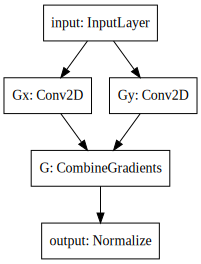

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [20]:
Gx = model.layers[1]
Gy = model.layers[2]

filterX = np.reshape(Gx.get_weights()[0], newshape=(3, 3))
filterY = np.reshape(Gy.get_weights()[0], newshape=(3, 3))
print('Filter in X direction:\n', filterX)
print('\nFilter in Y direction:\n', filterY)

Filter in X direction:
 [[ 0.16081032  0.54362899 -0.53473699]
 [ 0.40717685 -0.25980818 -0.18085006]
 [-0.10124318 -0.4918848   0.44546008]]

Filter in Y direction:
 [[ 0.19576937 -0.35977668  0.26984391]
 [ 0.13819773  0.39018691 -0.3499482 ]
 [-0.19980982  0.25051445 -0.33588222]]


### Evaluation on testing dataset

In [18]:
def evaluate(inputs, labels, apply_thresholding=None):
    predictions = model.predict(inputs)
    
    if apply_thresholding:
        predictions = [apply_thresholding(prediction) for prediction in predictions]
    
    labels = np.array(labels) * 255.
    predictions = np.array(predictions) * 255.
    return ((labels - predictions) ** 2).mean(axis=None)

In [19]:
print('Neural Network without thresholding:', evaluate(test_input, test_label))
print('Neural Network with otsu thresholding:', evaluate(test_input, test_label, global_otsu_thresholding))

Neural Network without thresholding: 1326.52
Neural Network with otsu thresholding: 9045.47253525
